### Test UCL Repo Interaction

This notebook is just a test for integrating the functionality of UCL code repository into a Jupyter notebook.

<span style="color:red"> **Important notes to make it work ok:** </span>
* Add the UCL `LibModules` path to jupyter's module path.
* Ensure that the option `notebook=True` is passed to dm plotting functions, this is really important for `ginput` plots. It seems to completely break a Debian Stretch system if omitted (with manual Jupyter install outside Anaconda).
* Ensure a GUI capable backend is used with `ginput`. Tk seems to work best, but Qt4 or 5 should work ok too.

In [2]:
#%matplotlib inline
import qutip as qt
import scipy as sc
import pickle
import sys
import os
import numpy as np
import matplotlib as mpl

# Change some MPL settings
#mpl.rcParams.update({'font.size':22}) # This break the dm plotting
mpl.use('TkAgg',warn=True, force=True)
import matplotlib.pyplot as plt

# Progress bar yay
from ipywidgets import FloatProgress

# Temporary fix for embedding dm images using ginput
from IPython.display import Image

# Get library path for UCL repository
ucl_lib_path = "/home/dustyd/Documents/PostDoc/Repositories/MarsPythonAPI/ucl-measurement-code/LibModules"
sys.path.append(ucl_lib_path)

# Get UCL modules
import data_management as dm
import physical_constants as pc


In [3]:
# Create the analyser instance
bd = "/home/dustyd/Documents/PostDoc/Repositories/PaperRepos/jc-csfq-fitting-code/"
USER = "C6_XT_GB_L4_UID2 Characterisation"
EXPERIMENT = "Jupyter Session 1"
AN = dm.Analysis(USER,EXPERIMENT,base_dir=bd)
AN.showConfig()

Current Data Analysis Configuration:
 user = 	C6_XT_GB_L4_UID2 Characterisation
 experiment = 	Jupyter Session 1
 start_time = 	Wed May  1 17:44:59 2019
 path = 	/home/dustyd/anaconda3/lib/python3.6/site-packages
 script = 	ipykernel_launcher.py
 anal_dir = 	/home/dustyd/Documents/PostDoc/Repositories/PaperRepos/jc-csfq-fitting-code/C6_XT_GB_L4_UID2 Characterisation/Data Analysis/2019-05-01 Jupyter Session 1/


In [4]:
# Get the processed result files
search_dir = "2019-04-25 X1Z1 Flux Modulation QB2 Wide Band Avg Analysis 3"
fl = AN.getAnalFileList(USER,search_dir,pattern="*full.bin")
print (fl)

['/home/dustyd/Documents/PostDoc/Repositories/PaperRepos/jc-csfq-fitting-code/C6_XT_GB_L4_UID2 Characterisation/Data Analysis/2019-04-25 X1Z1 Flux Modulation QB2 Wide Band Avg Analysis 3/resonator_pull_map_full.bin']


In [5]:
# Load the X/Z flux data and the resonator frequency obtained from finding the S21 minimum
obj = AN.fromFormattedData(fl[0])
print ("Data description:")
print (obj[0])
X = obj[1]
Y = obj[2]
alldata = obj[3]
Z = alldata[0]

Data description:
Format of this data: description,Xflux,Zflux,[s21m_f,r^2,fr,Qinc,Qidc,Qcdc,Ql,phi0,splp]


[[-0.54673968]
 [-0.38064006]]


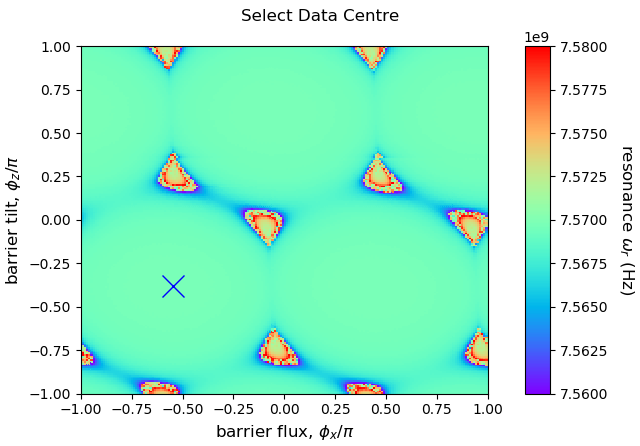

In [6]:
# Get data offset
offset = dm.plotMap("Select Data Centre",
                    X,
                    'barrier flux, $\phi_x/\pi$',
                    Y,
                    'barrier tilt, $\phi_z/\pi$',
                    Z.T,
                    'resonance $\omega_r$ (Hz)',
                    AN.anal_dir+"s21m_min_fdip_offset.png",
                    notebook=True,
                    raw=True,
                    ginput=1
                   )
print (offset)
Image(AN.anal_dir+"s21m_min_fdip_offset.png")

In [7]:
# Regen XY data with offset
Xo = X - offset[0]
Yo = Y - offset[1]

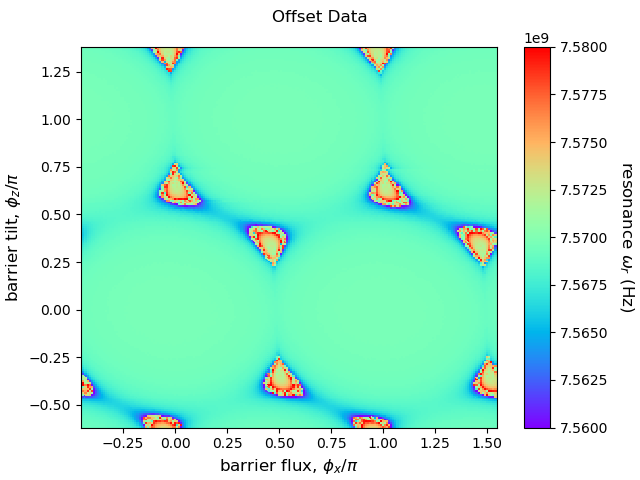

In [8]:
# Show data with offset applied
dm.plotMap("Offset Data",
                    Xo,
                    'barrier flux, $\phi_x/\pi$',
                    Yo,
                    'barrier tilt, $\phi_z/\pi$',
                    Z.T,
                    'resonance $\omega_r$ (Hz)',
                    AN.anal_dir+"s21m_min_fdip_offset_applied.png",
                    notebook=True,
                    raw=True
            )
Image(AN.anal_dir+"s21m_min_fdip_offset_applied.png")

[[0.13836643 0.88282155]
 [0.66223091 0.16699736]]


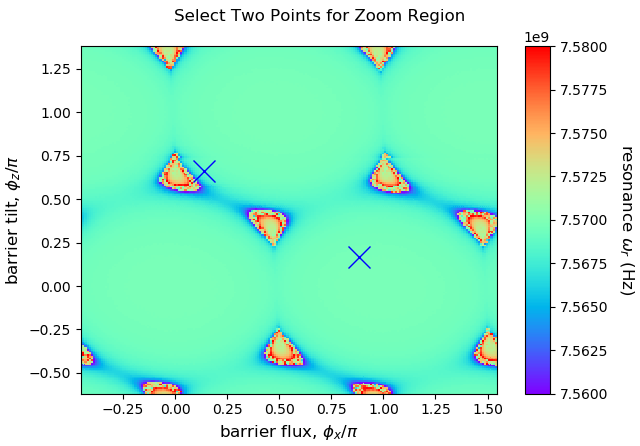

In [12]:
# Get selection rectangle
pts = dm.plotMap("Select Two Points for Zoom Region",
                 Xo,
                 'barrier flux, $\phi_x/\pi$',
                 Yo,
                 'barrier tilt, $\phi_z/\pi$',
                 Z.T,
                 'resonance $\omega_r$ (Hz)',
                 AN.anal_dir+"s21m_min_fdip_crop_select.png",
                 notebook=True,
                 raw=True,
                 ginput=2
                )
print (pts)
Image(AN.anal_dir+"s21m_min_fdip_crop_select.png")

In [13]:
# Get 1D sweeps
Xlin = Xo[:,0]
Ylin = Yo[0,:]
# Find the indices of the data corresponding to selection
newX,newY,newZ = dm.cropData(pts[0],pts[1],Xlin,Ylin,Z.T)

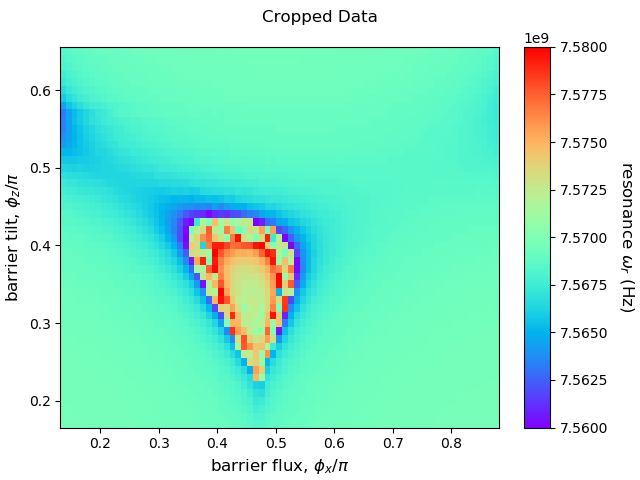

In [14]:
# Show cropped data
dm.plotMap("Cropped Data",
                    newX,
                    'barrier flux, $\phi_x/\pi$',
                    newY,
                    'barrier tilt, $\phi_z/\pi$',
                    newZ,
                    'resonance $\omega_r$ (Hz)',
                    AN.anal_dir+"s21m_min_fdip_crop_applied.png",
                    notebook=True
            )
Image(AN.anal_dir+"s21m_min_fdip_crop_applied.png")

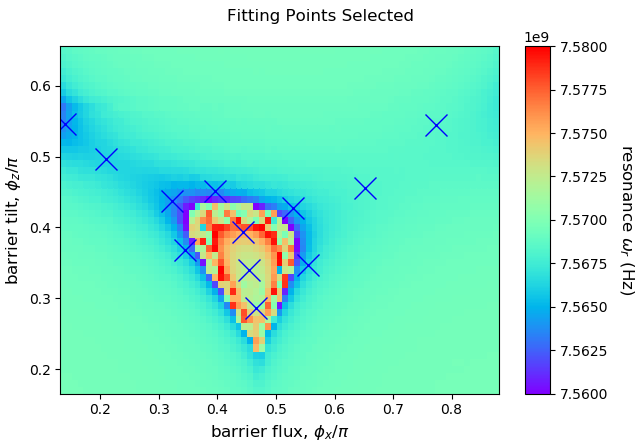

In [16]:
# Manually choose points for fitting
fit_pts = dm.plotMap("Fitting Points Selected",
                    newX,
                    'barrier flux, $\phi_x/\pi$',
                    newY,
                    'barrier tilt, $\phi_z/\pi$',
                    newZ,
                    'resonance $\omega_r$ (Hz)',
                    AN.anal_dir+"s21m_min_fdip_fitpts.png",
                    notebook=True,
                    ginput = 12
            )
Image(AN.anal_dir+"s21m_min_fdip_fitpts.png")

In [17]:
fit_pts

array([[0.13952208, 0.20956876, 0.32232683, 0.39579042, 0.34453675,
        0.44362718, 0.4658371 , 0.45387791, 0.52904996, 0.5546768 ,
        0.65205877, 0.77335912],
       [0.54593929, 0.4965599 , 0.43730463, 0.45141303, 0.36817348,
        0.3935686 , 0.28634477, 0.33995669, 0.42742875, 0.34701088,
        0.45564555, 0.54452845]])

In [18]:
# Get the indices corresponding to the specified values
Xindices = [(np.abs(np.array(newX) - val)).argmin() for val in fit_pts[0]]
Yindices = [(np.abs(np.array(newY) - val)).argmin() for val in fit_pts[1]]

In [20]:
# Get actual values
Xsel = np.array([newX[i] for i in Xindices])
Ysel = np.array([newY[i] for i in Yindices])
Zsel = np.array([newZ[i,j] for i,j in list(zip(Xindices,Yindices))])

In [21]:
Zsel

array([7.563500e+09, 7.566267e+09, 7.563833e+09, 7.564233e+09,
       7.565133e+09, 7.575300e+09, 7.571000e+09, 7.572233e+09,
       7.565567e+09, 7.566233e+09, 7.568267e+09, 7.568467e+09])

Ok now we are ready to do the fitting:
___

First fit leaving many parameters free, including the known ones, to get a best fit.

In [38]:
import lmfit_residuals as resid
import lmfit
import time

# Initial parameters
ip = lmfit.Parameters()
ip.add_many(('g0',0.01906011,True,0.01,0.5,None),
            ('asy',-0.13863083,True,-0.5,0.5,None),
            ('wr',7.569733,False,None,None,None),
            ('Ajj',0.10761000,True,0.02,1.0,None),
            ('Csh',220e-15,False,45e-15,500e-15,None),
            ('alpha',0.97,False,0.1,1.0,None),
            ('Jc',3.0,False,1.0,5.0,None),
            ('Ca',60.0,False,30.0,90.0,None),
            ('trunc',80,False,10,120,None),
            ('nmax',5,False,1,10,None)
           )

# Do fit in two steps:
# Nelder-Mead to close in on global minimum, Levenberg-Marquart to refine result and determine statistics
st = time.time()
print ("Fitting... ",end="")
rsquare,lmp,report = AN.performFit(resid.csfq_jc_resid,ip,(Xsel,Ysel),Zsel,sequence=["nelder","leastsq"])
tt = time.time() - st
params = lmp.valuesdict()
print ("Done.")

Fitting... Done.


NameError: name 'model1' is not defined

In [39]:
# Report
print ("Converged in %i iterations in %f s\n" % (resid.iterations,tt))
print (report)
print ("\nr^2 = %f\n" % rsquare)
print (params)

Converged in 464 iterations in 367.017715 s

[[Variables]]
    g0:     0.26196012 +/- 0.07866265 (30.03%) (init = 0.2619601)
    asy:   -0.50000000 +/- 0.02318815 (4.64%) (init = -0.5)
    wr:     7.569733 (fixed)
    Ajj:    1.00000000 +/- 0.01149833 (1.15%) (init = 1)
    Csh:    2.2e-13 (fixed)
    alpha:  0.97 (fixed)
    Jc:     3 (fixed)
    Ca:     60 (fixed)
    trunc:  80 (fixed)
    nmax:   5 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(asy, Ajj) = -0.571
    C(g0, asy)  =  0.209
    C(g0, Ajj)  =  0.201

r^2 = -0.011085

OrderedDict([('g0', 0.26196012358063514), ('asy', -0.49999999999925043), ('wr', 7.569733), ('Ajj', 0.9999999999998113), ('Csh', 2.2e-13), ('alpha', 0.97), ('Jc', 3.0), ('Ca', 60.0), ('trunc', 80), ('nmax', 5)])


In [69]:
phizpts = np.linspace(-np.pi,np.pi,200)
phixpts = np.linspace(-2*np.pi,2*np.pi,200)
trunc=80

# Charge operator
Q = qt.num(trunc,-(trunc - 1)/2)

# Charge raising operator
Dp = qt.qeye(trunc) - qt.qeye(trunc)
for i in range(trunc-1):
    Dp += qt.basis(trunc,i)*qt.basis(trunc,i+1).dag()

# Charge lowering operator
Dm = Dp.dag()

# Z flux dependence
zres = np.array([sc.linalg.eigvals(resid.csfq_H(2*np.pi,z,3.0,60,0.05,0.97,220e-15,trunc=trunc,Q=Q,Dp=Dp,Dm=Dm)) for z in phizpts])

# X flux dependence
xres = np.array([sc.linalg.eigvals(resid.csfq_H(x,np.pi,3.0,60,0.05,0.97,220e-15,trunc=trunc,Q=Q,Dp=Dp,Dm=Dm)) for x in phixpts])

In [70]:
Ez = zres[:,1]-zres[:,0]
Ex = xres[:,1]-xres[:,0]

Populating the interactive namespace from numpy and matplotlib


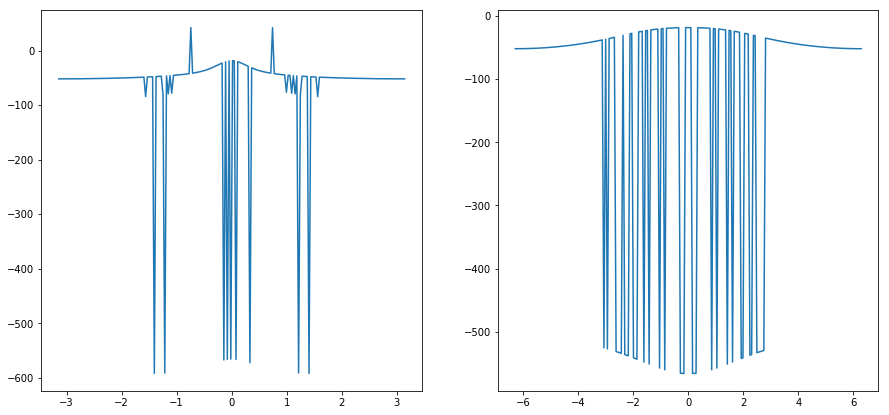

In [71]:
%pylab inline
fig = plt.figure(figsize=(15,7))
ax1 = plt.subplot(121)
ax1.plot(phizpts,Ez)
ax2 = plt.subplot(122)
ax2.plot(phixpts,Ex)
plt.show()

In [78]:
#
# CSFQ Class
#
class CSFQ_Qubit:
    
    # Required parameters (keys)
    params_required = ["Jc",# Critical current density (FAB)
                       "Ca",# Capacitance density (FAB)
                       "Ajj",# Large junction area
                       "Csh",# Shunt capacitance
                       "alpha",# Ratio of small to large JJ area
                       "trunc"# Operator truncation
                      ]
    
    # Optional parameters (keys)
    params_optional = ["Cs", # Stray capacitance
                       "Xasy" # X loop JJ asymmetry
                      ]
    
    # External parameters
    params_ext = ["phi_x",
                  "phi_z"
                 ]
    
    # Energy units
    units_energy = ["J", # Joules
                    "GHz" # GHz
                   ]
    
    # Parameter sweep output options
    sweep_output = ["E", # Eigenenergies only
                    "EandS" # Eigenenergies and states
                   ]
    
    # Initialisation
    def __init__(self,csfq_params):
        
        # Update required parameters
        if csfq_params:
            missing = []
            for key in CSFQ_Qubit.params_required:
                if key not in list(csfq_params.keys()):
                    missing.append(key)
            if missing != []:
                raise Exception("Missing parameters in CSFQ parameter list:\n\t %s" % missing)
        else:
            raise Exception("Empty CSFQ parameter list.")
        self.params = csfq_params
        
        # Update optional parameters
        
        # Construct the operators
        self.op_charge_number()
        self.op_charge_raising()
        self.op_charge_lowering()
    
    # Print CSQF information
    def info(self):
        for k in list(self.params.keys()):
            print ("[%s] = %e" % (k,self.params[k]))
        print ("[Csigma] = %e F" % self.get_Csigma())
        print ("[Ec] = %e GHz" % self.get_Ec())
        print ("[Ej (large)] = %e GHz" % self.get_large_Ej())
        print ("[Ej (small)] = %e GHz" % self.get_small_Ej())
        print ("[Ej/Ec] = %.1f\n" % (self.get_small_Ej()/self.get_Ec()))
    
    # Get total capacitance seen by small junction (F)
    def get_Csigma(self):
        
        # Small junction
        Csmall = self.params["alpha"]*self.params["Ajj"]*self.params["Ca"]*1e-15 + self.params["Csh"]
        
        # Large junctions (in series)
        Clarge = 0.5*self.params["Ajj"]*self.params["Ca"]*1e-15
        
        return Csmall + Clarge
    
    # Get small junction energy (J)
    def get_small_Ej(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy.")
        if unit == "J":
            return self.params["alpha"]*self.params["Ajj"]*self.params["Jc"]*pc.phi0/(2*np.pi) * 1e-6
        elif unit == "GHz":
            return self.params["alpha"]*self.params["Ajj"]*self.params["Jc"]*pc.phi0/(4*np.pi**2*pc.hbar) * 1e-15
    
    # Get large junction energy (J)
    def get_large_Ej(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy.")
        if unit == "J":
            return self.params["Ajj"]*self.params["Jc"]*pc.phi0/(2*np.pi) * 1e-6
        elif unit == "GHz":
            return self.params["Ajj"]*self.params["Jc"]*pc.phi0/(4*np.pi**2*pc.hbar) * 1e-15
    
    # Get charging energy seen by small junctions
    def get_Ec(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy '%s'." % unit)
        if unit == "J":
            return 2*pc.e**2/self.get_Csigma()
        elif unit == "GHz":
            return 2*pc.e**2/(self.get_Csigma()*2*np.pi*pc.hbar) * 1e-9
    
    # Create charge operator
    def op_charge_number(self):
        if hasattr(self,"op_n"):
            return self.op_n
        else:
            self.op_n = qt.num(self.params["trunc"],-(self.params["trunc"] - 1)/2)
    
    # Create charge raising operator
    def op_charge_raising(self):
        if hasattr(self,"op_Dp"):
            return self.op_Dp
        else:
            self.op_Dp = qt.qeye(self.params["trunc"]) - qt.qeye(self.params["trunc"])
            for i in range(self.params["trunc"]-1):
                self.op_Dp += qt.basis(self.params["trunc"],i)*qt.basis(self.params["trunc"],i+1).dag()
    
    # Create charge lowering operator
    def op_charge_lowering(self):
        if hasattr(self,"op_Dm"):
            return self.op_Dm
        else:
            if not hasattr(self,"op_Dp"):
                raise Exception("Define the raising operator first.")
            else:
                self.op_Dm = self.op_Dp.dag()
    
    # Create phase operator
    def op_phase(self):
        
        # Still need to find a way to express natively in qutip
        pass
    
    # Get Hamiltonian operator
    def op_hamiltonian(self,phi_x,phi_z,ret=False):
        
        # Always update
        self.op_H = 0.5*self.get_Ec()*self.op_n**2 - \
        self.get_large_Ej()*(self.op_Dp+self.op_Dm) + \
        0.5*self.get_small_Ej()*np.cos(phi_x/2)*(np.exp(1j*phi_z)*self.op_Dp**2+np.exp(-1j*phi_z)*self.op_Dm**2)
        if ret:
            return self.op_H
    
    # Get asymmetric Hamiltonian operator
    def op_hamiltonian_asy(self,phi_x,phi_z,ret=False):
        
        # Asymmetry factor and phase
        asy_f = np.sqrt(1 + self.params["Xasy"]**2 * np.tan(phi_x/2)**2)
        asy_p = np.arctan(self.params["Xasy"] * np.tan(phi_x/2))
        
        # Always update
        self.op_H = 0.5*self.get_Ec()*self.op_n**2 - \
        self.get_large_Ej()*(self.op_Dp+self.op_Dm) + \
        asy_f*0.5*self.get_small_Ej()*np.cos(phi_x/2)*(np.exp(1j*(phi_z-asy_p))*self.op_Dp**2+np.exp(-1j*(phi_z-asy_p))*self.op_Dm**2)
        if ret:
            return self.op_H
    
    # External parameter sweep sub function
    def param_sweep_ext(self,param,ext_vars,sweep_var,output="E",ipy_pbar=True):
        
        # Empty the result variables
        self.sweep_var = []
        self.sweep_result = []
        
        # Check if using ipython progress bar
        if ipy_pbar:
            
            # Setup progress bar
            f = FloatProgress(min=0, max=len(sweep_var))
            print("'%s' sweep progress:" % param)
            display(f)
            
            if param == "phi_x":
                if output == "EandS":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        self.sweep_result.append(self.op_H.eigenstates())
                        f.value+=1
                elif output == "E":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
                        f.value+=1
            if param == "phi_z":
                if output == "EandS":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        self.sweep_result.append(self.op_H.eigenstates())
                        f.value+=1
                elif output == "E":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
                        f.value+=1
        else:
            if param == "phi_x":
                if output == "EandS":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        self.sweep_result.append(self.op_H.eigenstates())
                elif output == "E":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
            if param == "phi_z":
                if output == "EandS":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        self.sweep_result.append(self.op_H.eigenstates())
                elif output == "E":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
        
        # Return result in suitable format
        self.sweep_result = np.array(self.sweep_result).T
        self.sweep_var = sweep_var
        return (sweep_var,self.sweep_result)
    
    # Static linear parameter sweep
    def param_sweep_lin(self,param,ext_vars,start,end,num,overwrite=False,output="E",ipy_pbar=True):
        
        # 
        if output not in CSFQ_Qubit.sweep_output:
            raise Exception("Unrecognised sweep output option '%s'." % output)
        
        if param not in CSFQ_Qubit.params_ext and param not in CSFQ_Qubit.params_required and param not in CSFQ_Qubit.params_optional:
            raise Exception("Unrecognised sweep parameter '%s'." % param)
        
        if not overwrite:
            if hasattr(self,"sweep_result"):
                raise Exception("Not overwritting existing sweep_result.")
        
        # Create the parameter sweep array
        sweep_var = np.linspace(start,end,num)
        
        # Perform sweep on desired external parameter
        if param in CSFQ_Qubit.params_ext:
            return self.param_sweep_ext(param,ext_vars,sweep_var,output=output,ipy_pbar=ipy_pbar)
        
        # Perform sweep on desired internal parameter
        # TODO
        elif param in CSFQ_Qubit.params_required:
            pass

In [79]:
# MIT early CSFQs

# Create qubits
qubit1_params = {"Ajj":0.1,"alpha":0.97,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

qubit2_params = {"Ajj":0.1,"alpha":0.4,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit2 = CSFQ_Qubit(qubit2_params)
qubit2.info()

# Z Parameter sweep
phi_x = 0.0
z_pts1,Ez_pts1 = qubit1.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)
z_pts2,Ez_pts2 = qubit2.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)

# X Parameter sweep
phi_z = 0.0
x_pts1,Ex_pts1 = qubit1.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)
x_pts2,Ex_pts2 = qubit2.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)

[Ajj] = 1.000000e-01
[alpha] = 9.700000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.288200e-13 F
[Ec] = 3.386108e-01 GHz
[Ej (large)] = 1.490051e+02 GHz
[Ej (small)] = 1.445349e+02 GHz
[Ej/Ec] = 426.8

[Ajj] = 1.000000e-01
[alpha] = 4.000000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.254000e-13 F
[Ec] = 3.437485e-01 GHz
[Ej (large)] = 1.490051e+02 GHz
[Ej (small)] = 5.960202e+01 GHz
[Ej/Ec] = 173.4

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

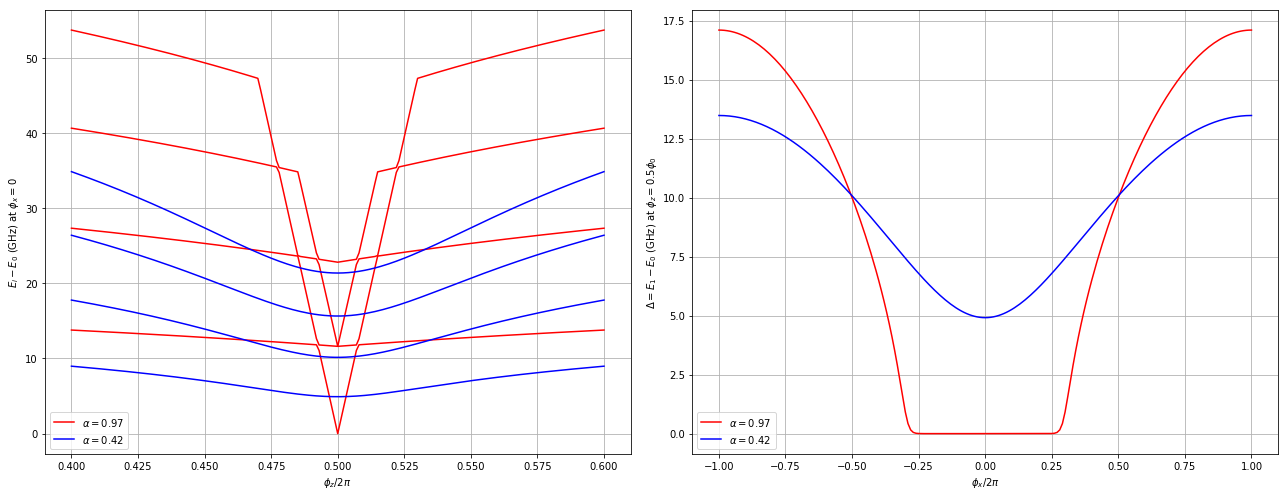

In [80]:
# Plot CSFQ energy levels
fig = plt.figure(figsize=(18,7))

ax1 = plt.subplot(121)
for i in range(4):
    ax1.plot(z_pts1/(np.pi*2)+0.5, Ez_pts1[i+1]-Ez_pts1[0],"r-",label="$\\alpha=0.97$")
    ax1.plot(z_pts2/(np.pi*2)+0.5, Ez_pts2[i+1]-Ez_pts2[0],"b-",label="$\\alpha=0.42$")
ax1.set_xlabel('$\phi_z/2\pi$')
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$')
h1,l1 = ax1.get_legend_handles_labels()
ax1.grid()
ax1.legend(h1[:2],l1[:2])

ax2 = plt.subplot(122)
ax2.plot(x_pts1/(np.pi*2), Ex_pts1[1]-Ex_pts1[0],"r-",label="$\\alpha=0.97$")
ax2.plot(x_pts2/(np.pi*2), Ex_pts2[1]-Ex_pts2[0],"b-",label="$\\alpha=0.42$")
ax2.set_xlabel('$\phi_x/2\pi$')
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz) at $\phi_z = 0.5\phi_0$')
ax2.grid()
ax2.legend()

fig.tight_layout()